In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os
from configparser import ConfigParser

In [0]:
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read('cifar10_config.txt')
batch_size = cfg.getint('parameters','batch_size')
epochs = cfg.getint('parameters','epochs')
learning_rate = cfg.getfloat('parameters','learning_rate')
dropout_rate = cfg.getfloat('parameters','dropout_rate')

In [0]:

num_classes = 10

data_augmentation = True

In [0]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
x_train.shape[1:]

(32, 32, 3)

In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
 

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
 
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_81 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_82 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 15, 32)        0         
__________

In [0]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=learning_rate, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/30
1563/1563 [==============================] - 62s 40ms/step - loss: 1.5649 - acc: 0.4421 - val_loss: 1.2340 - val_acc: 0.5671
Epoch 2/30
1563/1563 [==============================] - 58s 37ms/step - loss: 1.1453 - acc: 0.5946 - val_loss: 1.0748 - val_acc: 0.6266
Epoch 3/30
1563/1563 [==============================] - 58s 37ms/step - loss: 0.9806 - acc: 0.6577 - val_loss: 0.8915 - val_acc: 0.6932
Epoch 4/30
1563/1563 [==============================] - 58s 37ms/step - loss: 0.8785 - acc: 0.6946 - val_loss: 0.8492 - val_acc: 0.7093
Epoch 5/30
1563/1563 [==============================] - 58s 37ms/step - loss: 0.8150 - acc: 0.7162 - val_loss: 0.7605 - val_acc: 0.7480
Epoch 6/30
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7740 - acc: 0.7329 - val_loss: 0.7981 - val_acc: 0.7317
Epoch 7/30
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7444 - acc: 0.7478 - val_loss: 0.7439 - val_acc: 0.7566
Epoch 8/30
15

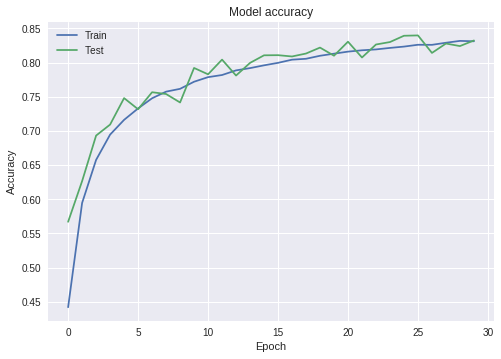

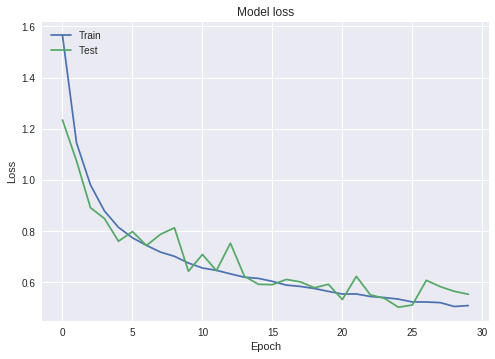

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()